In [23]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"
import models.rebuild_DL1 as DL1

#model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
#model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()

#filename.root:Tdirectory/directory/obj
File_path="BTagCalibRUN2-08-40.root:DL1/AntiKt4EMTopo/net_configuration"

DL1_struct = DL1.get_net_struct(File_path)
DL1_weights = DL1_struct['layers']

#DL1_layers = [ 72, 57, 60, 48, 36,24, 12, 6]
DL1_dropouts = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

#findout input size, and weight matrix for each layer.
#create corresponding tensorflow layers and store them in a list.
features, dl1_layers, dl1_weights = DL1.pars_layers(DL1_struct['layers'])

model = DL1.get_DL1(features , dl1_layers, drops=None )
model_dropout = DL1.get_DL1(features , dl1_layers, drops=DL1_dropouts )
#model.summary()
DL1.set_dl1_weights(model=model, weights=dl1_weights)
DL1.set_dl1_weights(model=model_dropout, weights=dl1_weights)

import h5py
#get test dataset
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/MC16_ttbar-test-even-bjets.h5", 'r')
X_test, Y_test = hf['X_test'][:10000], hf['Y_test'][:10000]
hf.close()

def DL1_socre(pb, pc, pl): 
    return np.log(pb/(0.08*pc + 0.92*pl))

def plot_prob_score(pb, pc, pl, DL1_socre, range=(0,1)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=range, alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins, alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins, alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_socre(pb, pc, pl), 100, alpha=0.6)
    
def get_mean_score(X_test, model):
    def _mean_score(inputs):
        result_prob = model(np.array(100*[inputs]), training=False).numpy()
        result = DL1_socre(result_prob[:,2], result_prob[:,1], result_prob[:,0])
        return result.mean(), result.std()

    return np.apply_along_axis(_mean_score,1, X_test)

In [24]:
re_dropout = model_dropout(np.array(10000*[X_test[9]]), training=False).numpy()

#no dropout
re = model(X_test, training=False).numpy()

mean_score = get_mean_score(X_test, model_dropout)

<ipython-input-23-342f5e04f1d6>:44: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))


In [25]:
score = DL1_socre(re[:,2],re[:,1], re[:,0])

In [29]:
Hpretag_jetPt, bins = np.histogram(X_test[:,1], 20)

#btagging
Htagged_jetPt, _ = np.histogram( X_test[(score>1.45)][:,1], bins=bins)

#btagging
Htagged_jetPt_mean, _ = np.histogram( X_test[(mean_score[:,0]>1.45)][:,1], bins=bins)

<ipython-input-34-0ede8bd5a8da>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bins[:-1], Htagged_jetPt/Hpretag_jetPt, "r*")
<ipython-input-34-0ede8bd5a8da>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(bins[:-1], Htagged_jetPt_mean/Hpretag_jetPt, "b.")


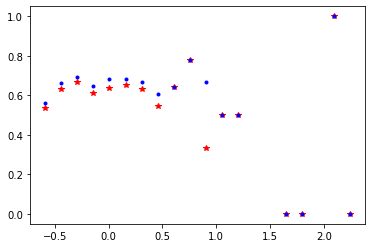

In [34]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(bins[:-1], Htagged_jetPt/Hpretag_jetPt, "r*")
plt.plot(bins[:-1], Htagged_jetPt_mean/Hpretag_jetPt, "b.")

In [28]:
mean_score

array([[0.20071533, 0.28136128],
       [4.1484027 , 1.6845444 ],
       [6.2652006 , 2.3801525 ],
       ...,
       [4.9414253 , 2.1422412 ],
       [6.240187  , 2.6617453 ],
       [0.8301285 , 0.87456286]], dtype=float32)